In [1]:
from dvc.repo import Repo as DVCRepo
r = DVCRepo(r"D:\ig_pipeline")

In [2]:
stages = r.stages

In [23]:
r.lock.lock()

In [24]:
stages[0].changed()

False

In [4]:
dir(stages[0])

['PARAM_ALWAYS_CHANGED',
 'PARAM_CMD',
 'PARAM_DEPS',
 'PARAM_DESC',
 'PARAM_FROZEN',
 'PARAM_LIVE',
 'PARAM_LOCKED',
 'PARAM_MD5',
 'PARAM_META',
 'PARAM_METRICS',
 'PARAM_OUTS',
 'PARAM_PARAMS',
 'PARAM_PLOTS',
 'PARAM_WDIR',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_changed_deps',
 '_changed_entries',
 '_changed_stage_entry',
 '_check_can_merge',
 '_check_missing_outputs',
 '_checkout',
 '_dvcfile',
 '_path',
 '_read_env',
 '_run_stage',
 '_stage_text',
 '_status',
 '_status_always_changed',
 '_status_deps',
 '_status_outs',
 '_status_stage',
 '_sync_import',
 'addressing',
 'already_cached',
 'always_changed',
 'changed',
 'changed_deps',
 'changed_entries'

In [25]:
s_to_deps = {s: [d.fs_path for d in s.deps] for s in stages}
out_to_s = {o.fs_path: s for s in stages for o in s.outs}

In [32]:
import networkx as nx

In [39]:
G = nx.DiGraph()

In [40]:
def canonicalize(s):
    return s.name.split("@")[0] if not s.is_data_source else "data source"

In [42]:
# Process nodes
for s in s_to_deps.keys():
    this_node = canonicalize(s)
    if this_node not in G.nodes:
        G.add_node(this_node, total=0, changed=0)
        
    G.nodes[this_node]["total"] += 1
    if s.changed():
        G.nodes[this_node]["changed"] += 1
    
# Add dependencies
for s in s_to_deps.keys():
    this_node = canonicalize(s)
    for dep in s_to_deps[s]:
        if dep in out_to_s:
            from_node = canonicalize(out_to_s[dep])
            G.add_edge(from_node, this_node)

In [46]:
for f, t in G.edges:
    print(f"    {f} --> {t}")

    aggregate_metadata --> pack_dataset
    aggregate_objs --> aggregate_metadata
    aggregate_objs --> export_scene
    aggregate_objs --> pack_dataset
    aggregate_scenes --> aggregate_metadata
    aggregate_scenes --> pack_dataset
    export_meshes --> export_meshes_success
    export_meshes --> export_objs
    export_meshes --> export_scene
    export_meshes_success --> export_objs
    export_meshes_success --> export_scene
    export_objs --> aggregate_objs
    export_objs --> export_objs_success
    export_objs_success --> aggregate_objs
    export_scene --> aggregate_scenes
    export_scene --> validate_scene
    object_inventory --> aggregate_objs
    object_list --> export_meshes
    object_list --> export_objs
    object_list --> object_inventory
    object_list --> object_list_success
    object_list_success --> export_objs
    room_object_list --> combined_room_object_list
    sanitycheck --> sanitycheck_success
    data source --> export_meshes
    data source --> object

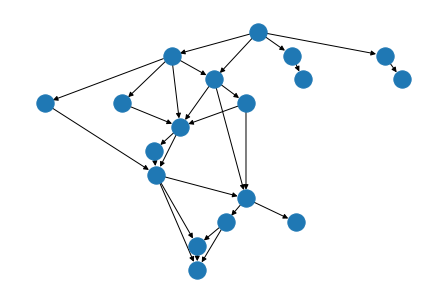

In [45]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
pos = graphviz_layout(G, prog="dot")
nx.draw(G, pos)
plt.show()

In [50]:
print("Completion ratios:")
for x in nx.topological_sort(G):
    completion_ratio = 1 - (G.nodes[x]["changed"] / G.nodes[x]["total"])
    completion_percentage = int(completion_ratio * 100)
    print(f"{x}: {completion_percentage}%")

Completion ratios:
data source: 99%
object_list: 67%
room_object_list: 100%
sanitycheck: 11%
export_meshes: 100%
object_inventory: 100%
object_list_success: 100%
combined_room_object_list: 0%
sanitycheck_success: 6%
export_meshes_success: 100%
export_objs: 100%
export_objs_success: 100%
aggregate_objs: 100%
export_scene: 100%
aggregate_scenes: 100%
validate_scene: 0%
aggregate_metadata: 100%
pack_dataset: 100%
